In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
AD_F = "../data/mitoDNA/cellSNP.tag.AD.mtx"
DP_F = "../data/mitoDNA/cellSNP.tag.DP.mtx"

In [3]:
# Parameters
AD_F = "data/chrM/PBMC_J_cellSNP_minC20_minAF0.1/cellSNP.tag.AD.mtx"
DP_F = "data/chrM/PBMC_J_cellSNP_minC20_minAF0.1/cellSNP.tag.DP.mtx"


In [4]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

In [5]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

0.4.2


In [6]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [7]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()

In [8]:
AD_shape = AD.todense().shape

## New implementation in v0.3.0

In [9]:
from vireoSNP import Vireo

Note, there are a few key parameters:

* `n_donor`: it means number of clones here, but you need to determine yourself. You can choose the one with highest ELBO (see next section)
* `n_GT`: number of different genotype. For somatic mutations, we could assume that there are only two, namely present or absent
* `is_theta_ASE`: whether allelic ratio is variant specific. For mitochondrial mutations, we choose True as allelic ratio can different from variant to variant

### Multiple initialization is needed to avoid local optima

In [10]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=3, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)

In [11]:
## Choose the model giving highest ELBO

_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_

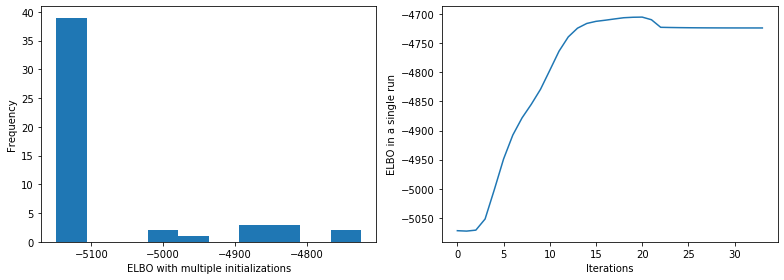

In [12]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist([x.ELBO_[-1] for x in _models_all])
plt.ylabel("Frequency")
plt.xlabel("ELBO with multiple initializations")

plt.subplot(1, 2, 2)
plt.plot(_losses)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")

plt.tight_layout()
plt.show()

In [13]:
print(modelCA.beta_mu),
print(modelCA.beta_sum)

[[0.09122 0.24140]
 [0.02614 0.32190]
 [0.01000 0.38286]
 [0.13893 0.17745]
 [0.20658 0.21624]
 [0.19727 0.20836]
 [0.13336 0.50000]]
[[3510.46793 1728.53207]
 [1103.57380 626.42620]
 [50.00000 747.00000]
 [4977.39559 2355.60441]
 [4408.50126 3749.49874]
 [4430.61474 3088.38526]
 [7847.00000 50.00000]]


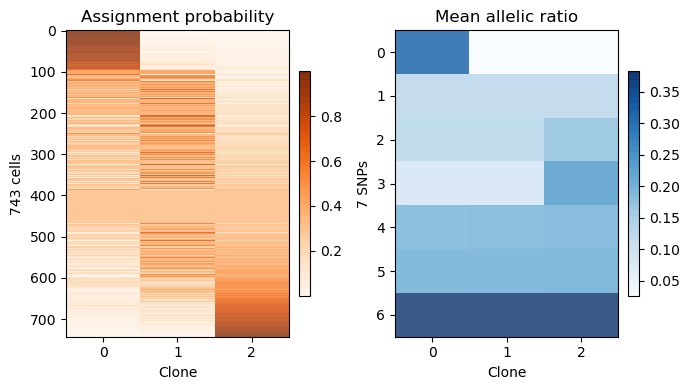

In [14]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.show()

In [15]:
np.sum(modelCA.predict_doublet(AD, DP)[0])

5.8348576649402215

### Choose the number of clones
We can choose the number of clones where ELBO stops increasing. Here, the best number of clone is 3.

Note, for a certain number of clone, e.g., n_clone=3, the ELBO may not the same for multiple initializations. This is becaused VI can only guarantee a local optima, so please choose the highest ELBO for each `n_clone` to represent its "global" optima.

In [16]:
n_initials = 50
n_clone_list = np.arange(2, 6)

_ELBO_mat = [] 
for k in n_clone_list:
    _elbo_temp = []
    for i in range(50):
        _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=k, n_GT=2,
                         fix_beta_sum=False, ASE_mode=True)
        _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
        _modelCA.fit(AD, DP, min_iter=20, verbose=False)
        _elbo_temp.append(_modelCA.ELBO_[-1])
    _ELBO_mat.append(_elbo_temp)

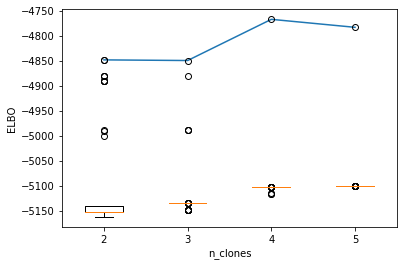

In [17]:
plt.plot([1, 2, 3, 4], np.max(_ELBO_mat, axis=1))
plt.boxplot(_ELBO_mat)
plt.xticks(n_clone_list - 1, n_clone_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

### Old version

The old version seem more likely to end up at local optima in this data set.

In [18]:
from vireoSNP.utils.vireo_wrap_v02 import vireo_flock

In [19]:
# theta_prior = np.array([[0.01, 10], [0.4, 10], [5, 5]])
theta_prior = np.array([[0.1, 10], [5, 5]])
res = vireo_flock(AD, DP, n_donor=3, learn_GT=True,
                  n_extra_donor=0, ASE_mode=True,
                  theta_prior=theta_prior, learn_theta=True,
                  n_init=50, check_doublet=False, random_seed=1)

[vireo] warm-up: 50 random initializations for 3 clusters...
[vireo] donor size with searching extra 0 donors:
donor0	donor1	donor2
248	248	248
[vireo] warm-up: lower bound ranges [-17098.5, -17098.5, -17098.5]
[vireo] main RUN with warm initials and tuned GT ...
[vireo] main RUN: 22 iterations; lower bound -17098.5
[vireo] beta parameters for binomial rate:
[[[0.10 0.10 0.10 0.10 0.10 0.10 0.10]
  [10.00 10.00 10.00 10.00 10.00 10.00 10.00]]

 [[717.00 210.00 266.00 1089.00 1701.00 1497.00 1051.00]
  [4432.00 1430.00 441.00 6154.00 6367.00 5932.00 6756.00]]]


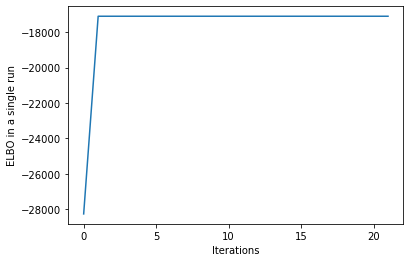

In [20]:
plt.plot(res['LB_list'])
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")
plt.show()

In [21]:
## If ASE_mode is True
AF_mean = res['theta_shapes'][:, 0] / np.sum(res['theta_shapes'], axis=1)

_new_shape = (AF_mean.shape[1], 1, AF_mean.shape[0])
AF_SNPs = np.sum(res['GT_prob'] * AF_mean.transpose().reshape(_new_shape), axis=2)

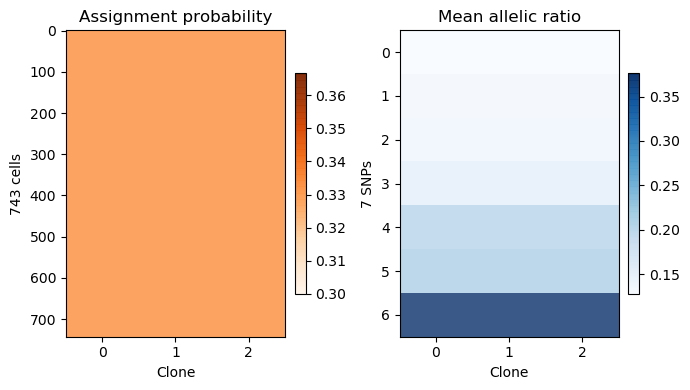

In [22]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(res['ID_prob'], cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.xlabel("Clone")
plt.xticks([0, 1, 2])

plt.subplot(1, 2, 2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.xticks([0, 1, 2])
plt.xlim(-0.5, 2.5)

plt.tight_layout()
plt.show()

## Plot K=4

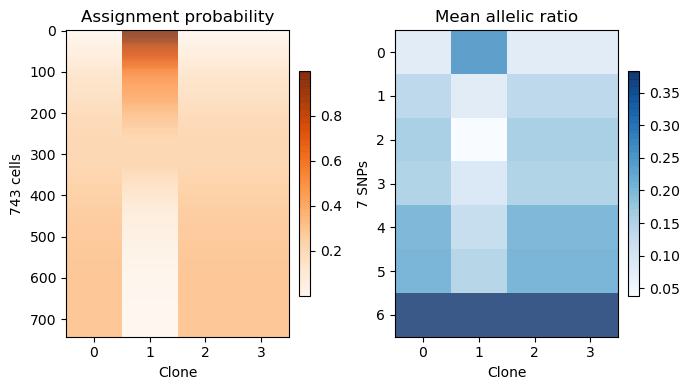

In [23]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=4, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)
    
## Choose the model giving highest ELBO

_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_


import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.show()